## PIMS Hackathon, Seattle 2025
### Project B - Preconditioners for Thermal Radiative Transfer
Packages: jupyter, numpy, matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from solvers import *
from post_process import *

L2  : 8.762331740438677e-10
Linf: 4.312269652473333e-09
Plot saved as /Users/rsz/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/daily_folders/Python/Test/PIMS_hack/PIMS-GroupB/test_figures/transport_plot.png


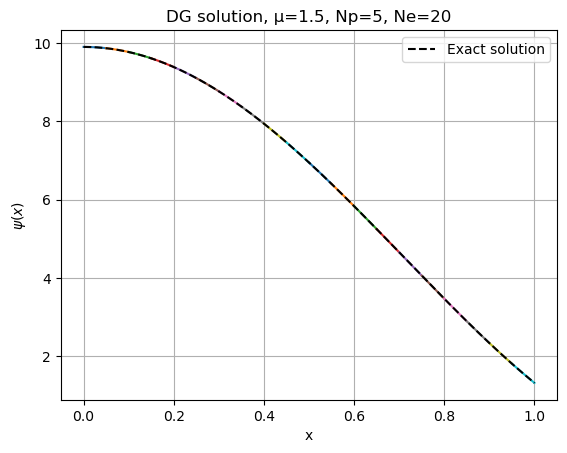

In [4]:
# ─── Example usage ───

# Parameters for the transport problem
μ       = 1.5
σ_t     = lambda x: x**2 + 1
source  = lambda x: (μ**3)*(2*x - 6.8*np.sin(2*x)) + (σ_t(x) * (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)))
inflow  = lambda x: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x))

# Mesh parameters
Ne = 20
xs      = np.linspace(0, 1, Ne + 1) # Mesh points / element boundaries
Np      = 5                     # Legendre polynomials per element (basis size)

# Plot numerical solution against the exact solution (MMS)
ψ_MMS     = lambda x: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x))
ψ_weights = transport_direct_solve(μ, σ_t, compute_source_term(source, Np, xs), inflow, Np, xs)
ψ_weights = ψ_weights.reshape(Ne, Np)

# Print the error in the solution
print("L2  :",error_Lp(ψ_weights, xs, Np, ψ_MMS, p=2))
print("Linf:",error_Lp(ψ_weights, xs, Np, ψ_MMS, p='inf'))
plot_solution(ψ_weights, xs, Np, μ=μ, exact_ψ_func=ψ_MMS, save_plot=True)

 12%|█▎        | 25/200 [00:03<00:21,  8.32it/s]


Converged in 25 iterations
Chosen μ: -0.6546536707079773
L2  : 1.657725563016653e-12
Linf: 4.560130051345368e-12


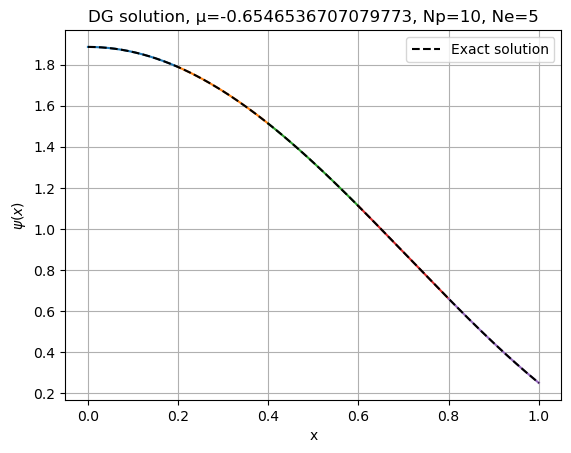

In [102]:
# ─── Example usage (Fixed point iteration) ───

# Parameters for the transport problem
ψ_MMS  = lambda x,μ: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)) # Manufactured solution
σ_t    = lambda x: x**3 + 1
σ_a    = lambda x: x**2 + 1
ε      = 0.5
source = lambda x,μ: (μ**3)/ε * (2*x - 6.8*np.sin(2*x)) + (σ_t(x)/ε**2 * ψ_MMS(x,μ)) \
                   - (σ_t(x)/ε - ε*σ_a(x)) / (3*ε) * ((x**2 +1) + 3.4*np.cos(2*x))
inflow = lambda x,μ: ψ_MMS(x,μ)
 
# Mesh parameters
Np = 10                      # Legendre polynomials per element (basis size)
Nμ = 5                      # Legendre polynomials per element (basis size)
xs = np.linspace(0, 1, 6) # Mesh points / element boundaries

# Solve
ψ_weights_all, μs, t = transport_direct_solve_diffusive(σ_t, σ_a, ε, source, inflow, Np, Nμ, xs, 
                                                     max_iter=int(200), tol=1e-10, preconditioning=True)
μi = 1 # Chosen μ for the error calculation
μc = μs[μi]
print("Chosen μ:", μc)

# Print the error in the solution
print("L2  :",error_Lp(ψ_weights_all[μi,:,:], xs, Np, lambda x: ψ_MMS(x,μc), p=2))
print("Linf:",error_Lp(ψ_weights_all[μi,:,:], xs, Np, lambda x: ψ_MMS(x,μc), p='inf'))

# Plot numerical solution against the exact solution (MMS)
plot_solution(ψ_weights_all[μi,:,:], xs, Np, μ=μc, exact_ψ_func=lambda x: ψ_MMS(x,μc))


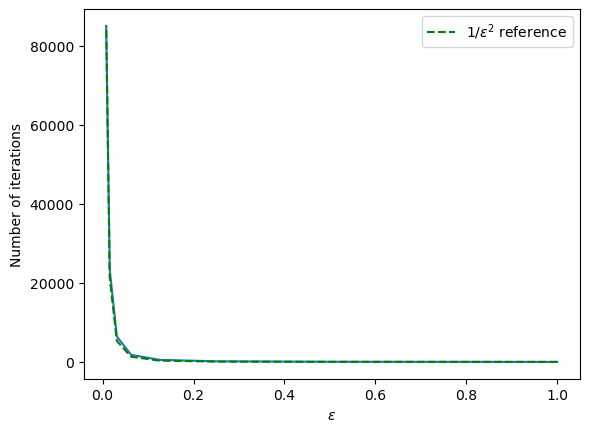

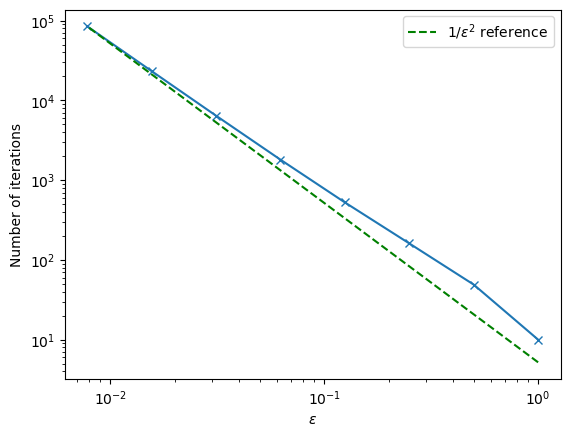

In [34]:
εs = [1*0.5**i for i in range(8)]
n_iter = []
for ε in εs:
    # Parameters for the transport problem
    ψ_MMS  = lambda x,μ: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)) # Manufactured solution
    σ_t    = lambda x: x**3 + 1
    σ_a    = lambda x: x**2 + 1
    source = lambda x,μ: (μ**3)/ε * (2*x - 6.8*np.sin(2*x)) + (σ_t(x)/ε**2 * ψ_MMS(x,μ)) \
                    - (σ_t(x)/ε - ε*σ_a(x)) / (3*ε) * ((x**2 +1) + 3.4*np.cos(2*x))
    inflow = lambda x,μ: ψ_MMS(x,μ)
    
    # Mesh parameters
    Np = 3                      # Legendre polynomials per element (basis size)
    Nμ = 5                      # Legendre polynomials per element (basis size)
    xs = np.linspace(0, 1, 6) # Mesh points / element boundaries

    # Solve
    ψ_weights_all, μs, t = transport_direct_solve_diffusive(σ_t, σ_a, ε, source, inflow, Np, Nμ, xs, 
                                                        max_iter=int(1e5), tol=1e-10)
    n_iter.append(t)

plt.plot(εs, n_iter)
plt.plot(εs, [n_iter[-1] * (εs[-1]/ε)**(2) for ε in εs], '--', label=f"$1/\epsilon^2$ reference", color = 'green')
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"Number of iterations")
plt.legend()
plt.savefig("test_figures/n_iter_vs_epsilon.pdf")
plt.show()

plt.plot(εs, n_iter, 'x-')
plt.plot(εs, [n_iter[-1] * (εs[-1]/ε)**(2) for ε in εs], '--', label=f"$1/\epsilon^2$ reference", color = 'green')
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"Number of iterations")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.savefig("test_figures/n_iter_vs_epsilon_log_log.pdf")
plt.show()

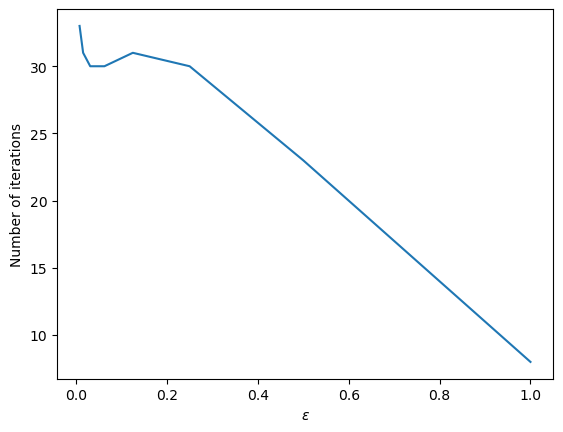

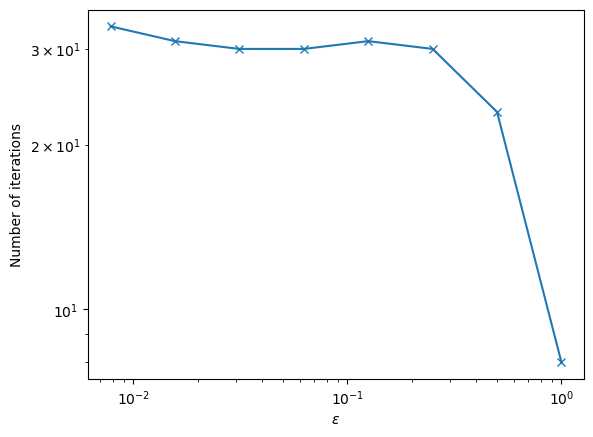

In [ ]:
εs = [1*0.5**i for i in range(8)]
n_iter_pre_con = []
for ε in εs:
    # Parameters for the transport problem
    ψ_MMS  = lambda x,μ: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)) # Manufactured solution
    σ_t    = lambda x: x**3 + 1
    σ_a    = lambda x: x**2 + 1
    source = lambda x,μ: (μ**3)/ε * (2*x - 6.8*np.sin(2*x)) + (σ_t(x)/ε**2 * ψ_MMS(x,μ)) \
                    - (σ_t(x)/ε - ε*σ_a(x)) / (3*ε) * ((x**2 +1) + 3.4*np.cos(2*x))
    inflow = lambda x,μ: ψ_MMS(x,μ)
    
    # Mesh parameters
    Np = 3                      # Legendre polynomials per element (basis size)
    Nμ = 5                      # Legendre polynomials per element (basis size)
    xs = np.linspace(0, 1, 6) # Mesh points / element boundaries

    # Solve
    ψ_weights_all, μs, t = transport_direct_solve_diffusive(σ_t, σ_a, ε, source, inflow, Np, Nμ, xs, 
                                                        max_iter=int(1e5), tol=1e-10, preconditioning=True)
    n_iter_pre_con.append(t)

plt.plot(εs, n_iter_pre_con)
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"Number of iterations")
plt.savefig("test_figures/n_iter_vs_epsilon_w_preconditioning.pdf")
plt.show()

plt.plot(εs, n_iter_pre_con, 'x-')
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"Number of iterations")
plt.xscale("log")
plt.yscale("log")
plt.savefig("test_figures/n_iter_vs_epsilon_w_preconditioning_log_log.pdf")
plt.show()

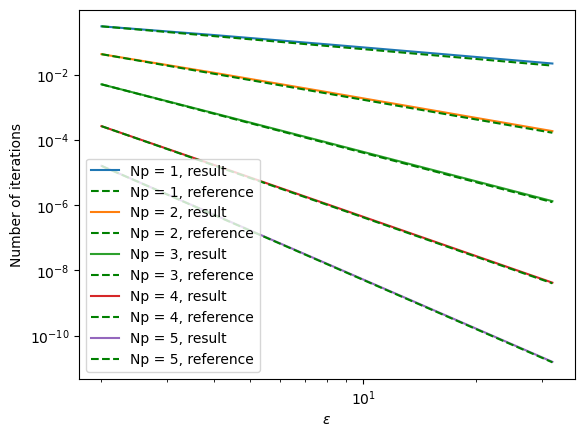

In [ ]:
# Nps = [1, 2, 3, 4, 5]
# Nes = [2, 4, 8, 16, 32]
# results = {}

for Np in Nps:
    results[Np] = []
    for Ne in Nes:
        ε = 0.9
        # Parameters for the transport problem
        ψ_MMS  = lambda x,μ: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)) # Manufactured solution
        σ_t    = lambda x: x**3 + 1
        σ_a    = lambda x: x**2 + 1
        source = lambda x,μ: (μ**3)/ε * (2*x - 6.8*np.sin(2*x)) + (σ_t(x)/ε**2 * ψ_MMS(x,μ)) \
                        - (σ_t(x)/ε - ε*σ_a(x)) / (3*ε) * ((x**2 +1) + 3.4*np.cos(2*x))
        inflow = lambda x,μ: ψ_MMS(x,μ)
        
        # Mesh parameters
        Nμ = 5                      # Legendre polynomials per element (basis size)
        xs = np.linspace(0, 1, Ne+1) # Mesh points / element boundaries

        # Solve
        ψ_weights_all, μs, t = transport_direct_solve_diffusive(σ_t, σ_a, ε, source, inflow, Np, Nμ, xs, 
                                                            max_iter=int(1e5), tol=1e-14)
        L2 = error_Lp(ψ_weights_all[μi,:,:], xs, Np, lambda x: ψ_MMS(x,μc), p=2)
        results[Np].append(L2)
        print(f"Np = {Np}, Ne = {Ne}, L2 = {L2}")
    plt.plot(Nes, results[Np], label=f"Np = {Np}, result")
    # dashed line
    plt.plot(Nes, [results[Np][0] * (Ne/2)**(-Np) for Ne in Nes], '--', label=f"Np = {Np}, reference", color = 'green')
plt.legend()
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"Number of iterations")
plt.xscale("log")
plt.yscale("log")
plt.savefig("test_figures/error_vs_Np_and_Ne.pdf")
plt.show()


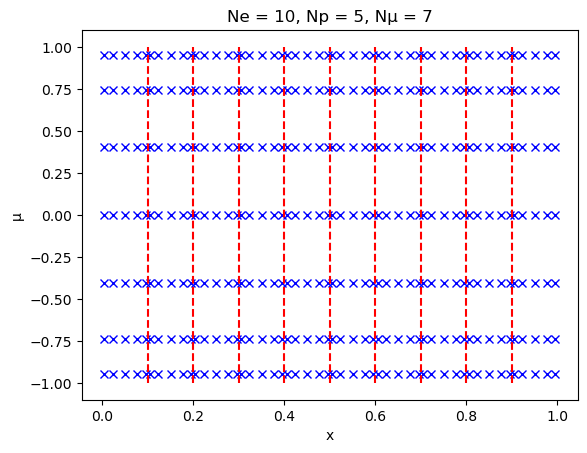

In [85]:
Ne = 10
Np = 5
Nμ = 7

μs, wμ = gausslegendre(Nμ)  # Interpolation points and weights
x, wx = gausslegendre(Np)  # Interpolation points and weights

for μ in μs:
    for i in range(Ne):
        plt.plot(((x+1)/2 + i)/Ne, np.zeros(Np) + μ, 'x', color='blue')

for i in range(Ne-1):
    plt.plot([(i+1)/Ne, (i+1)/Ne], [-1, 1], '--', color='red')
    
plt.title(f'Ne = {Ne}, Np = {Np}, Nμ = {Nμ}')
plt.xlabel('x')
plt.ylabel('μ')
plt.savefig(f'test_figures/Ne = {Ne}, Np = {Np}, Nμ = {Nμ}.pdf')
plt.show()

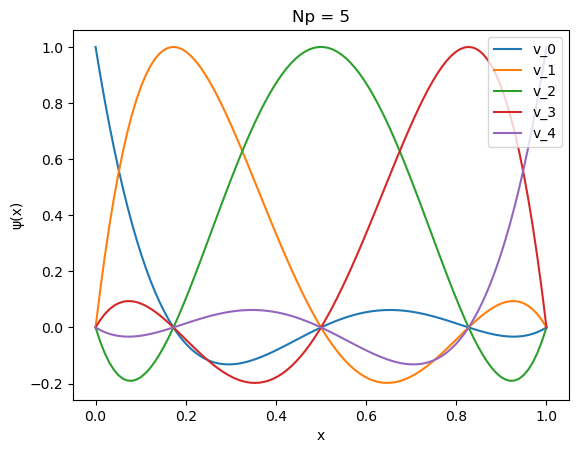

In [101]:
a, b = 0, 1
Ne = 1
Np = 5
num_plot_pts = 100

# interpolation nodes for Legendre basis ("b") funcs v_m
ξ_b, _ = gausslobatto(Np)
# plot points (in reference space [-1,1]) for each element
ξ_p = np.linspace(-1, 1, num_plot_pts)


x_p = ξ_to_x(ξ_p, a, b)

for i in range(Np):
    ψ_vals = eval_pk(ξ_p, i, ξ_b)
    plt.plot(x_p, ψ_vals, '-', label=f'v_{i}')
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('ψ(x)')
plt.title(f'Np = {Np}')
plt.savefig(f'test_figures/Np = {Np}.pdf')
plt.show()
